<a href="https://colab.research.google.com/github/Klinjin/134L/blob/main/M6/HR_M6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Phys\ 134L/M6/M6_e91/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1MxEorIsdb8fqiq1G4dgm7Vxx72QHGXkL/M6/M6_e91


#Sigma Clip Method

In [ ]:
!conda install -c conda-forge astroalign

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.0



# All requested packages already installed.



In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:19
🔁 Restarting kernel...


In [ ]:
!conda install -c conda-forge photutils

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - photutils


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aom-3.5.0                  |       h27087fc_0         2.7 MB  conda-forge
    asdf-2.15.0                |     pyhd8ed1ab_0         340 KB  conda-forge
    asdf-astropy-0.4.0         |     pyhd8ed1ab_1          51 KB  conda-forge
    asdf-coordinates-schemas-0.2.0|     pyhd8ed1ab_1          15 KB  conda-forge
    asdf-standard-1.0.3        |     pyhd8ed1ab_0          33 KB  conda-forge
    asdf-transform-schemas-0.3.0|     pyhd8ed1ab_0          55 KB  conda-forge
    asdf-unit-schemas-

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import *
import astroalign as aa
from photutils.background import Background2D, MedianBackground, MMMBackground
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry

In [ ]:
#First define the image in python as a string.
imagefile_g = "M6_g_align.fit"
imagefile_r = "M6_r_align.fit"
image_g=fits.open(imagefile_g)[0].data
header_g=fits.open(imagefile_g)[0].header
image_r = fits.open(imagefile_r)[0].data
header_r = fits.open(imagefile_r)[0].header

In [ ]:
print(image_g.shape)

<ipython-input-7-b5ef608cd8e8>:2: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(image_g), #We usually take the log of an image to see the variance of the pixels better.


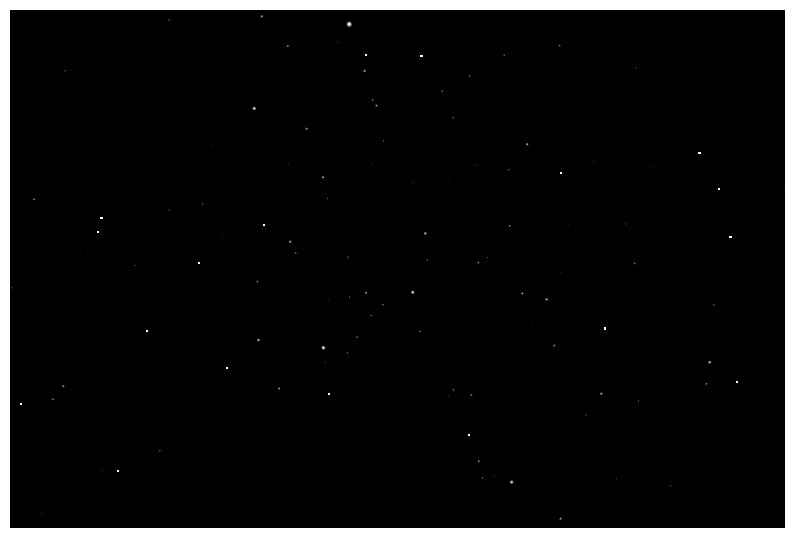

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(image_g), #We usually take the log of an image to see the variance of the pixels better.
            origin='lower', #This tells matplotlib where the [0,0] index is. For our images it is in the bottom.
            cmap = "gray", #Use whatever colormap you like, but I find gray the easiest to visualize.
            vmin = 6, vmax = 11) #This defines the data range we want to see. There are ways to automate this but I always do it manually.
plt.axis('off') #This removes the axes, which aren't really relevant for just viewing an image.
plt.show()

In [ ]:
mjd = header_g['MJD-OBS']
print("The Modified Julian Date is", mjd)

In [ ]:
sigma_clip = SigmaClip(sigma_lower=None, sigma_upper=None, cenfunc='mean') #doesn't change much for inf sigma
mean, median, std = sigma_clipped_stats(image_g,sigma_lower=None, sigma_upper=None, cenfunc='mean')

bkg_estimator = MedianBackground()
bkg = Background2D(image_g,
                    box_size=(10, 10),
                    filter_size=(9, 9),
                    sigma_clip=sigma_clip,
                    bkg_estimator=bkg_estimator)
bkg_ = bkg.background
bkg_median = bkg.background_median
bkg_rms = bkg.background_rms_median

mmm_bkg = MMMBackground()

daofind = DAOStarFinder(fwhm=1, #smaller <1, more bright stars
                        threshold=std*5,
                        brightest= 200)
sources = daofind(image_g - bkg_median) #doesn't change if not subtract bkg
print(sources)

In [ ]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid'])) #Positions are transposed by default.
apertures = CircularAperture(positions, r=15) #This defines an 'aperture' by radius around each source. The pixel values inside the aperture are summed to yield the photon count of the star.

#Lets plot our image again with the apertures overplotted to see how many stars we found.
plt.figure(figsize=(10,10))
plt.imshow(np.log(image_g), origin='lower', cmap = "gray", vmin=4, vmax = 11)
v = apertures.plot(color='red', lw=3, alpha=0.5)
plt.show()



```
# 此内容为代码格式
```

# Source Extractor Method

In [ ]:
!pip install sep

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sep

In [ ]:
datasw = image_g.byteswap(False).newbyteorder()

In [ ]:
bkg0=sep.Background(datasw)
data_sub=datasw-bkg0
objects = sep.extract(datasw-bkg0.back(), bkg0.globalrms*3, minarea =19, segmentation_map=False)
print(objects)

[(13.75331688,   56,   51, 1258, 1273,    0,    4, 1265.17998837, 1.24808717e+00, 13.16287616,  1.06904376,  1.84759655e-01, 0., 0., 0., 3.62845659, 1.03258014,  1.52724283e-02, 0.07615598, 0.93769014, -2.63236240e-02, 1.43848083e+03, 1.62290881e+03, 4.54904938e+01, 6.32597046e+01, 1265,    1, 1266,    0, 2)
 (13.75331688,   41,   37, 2911, 2920,    0,    4, 2915.70260462, 1.13882003e+00,  4.70071041,  1.07219206, -8.37415867e-02, 0., 0., 0., 2.16855764, 1.03453398, -2.30623595e-02, 0.2130302 , 0.93396825,  3.32766660e-02, 2.65661450e+03, 3.02082446e+03, 1.46807388e+02, 2.27148651e+02, 2916,    1, 2917,    0, 2)
 (13.75331688,   63,   54, 1079, 1090,    0,    5, 1084.30402806, 1.17082643e+00,  3.90653251,  1.34957882, -1.35091674e-01, 0., 0., 0., 1.97829473, 1.15864635, -5.26377298e-02, 0.25687066, 0.74354571,  5.14250621e-02, 8.91487109e+03, 1.00423027e+04, 6.62415649e+02, 1.05614343e+03, 1084,    1, 1085,    0, 2)
 (13.75331688,   37,   35, 1183, 1189,   10,   15, 1185.74239881, 1.24

<Figure size 1000x1000 with 0 Axes>

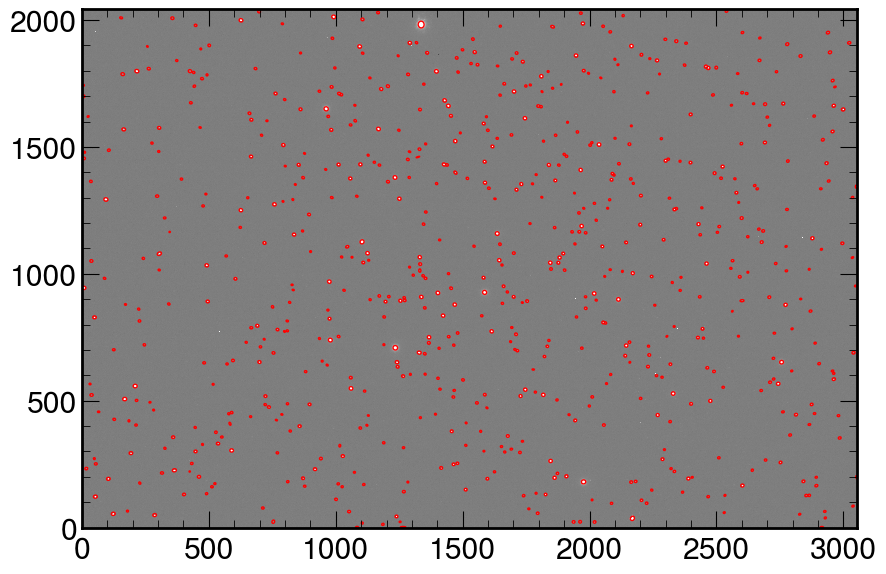

In [ ]:
from matplotlib.patches import Ellipse
# plot background-subtracted image
plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
vmin=m-s, vmax=m+s, origin='lower')
#m-s
# plot an ellipse for each object
for i in range(len(objects)):
  e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
  width=6*objects['a'][i],
  height=6*objects['b'][i],
  angle=objects['theta'][i] * 180. / np.pi)
  e.set_facecolor('none')
  e.set_edgecolor('red')
  ax.add_artist(e)

In [ ]:
def photometry(data, data2):
    datasw = data.byteswap(False).newbyteorder()
    bkg0=sep.Background(datasw)
    data_sub=datasw-bkg0
    objects = sep.extract(datasw-bkg0.back(), bkg0.globalrms*3, minarea =10, segmentation_map=False)
    positions_ = np.transpose((objects['x'], objects['y']))

    apertures = CircularAperture(positions_, r=5)
    phot_table = aperture_photometry(data_sub, apertures)
    aperture_sums_ = phot_table['aperture_sum']

    data2sw = data2.byteswap(False).newbyteorder()
    bkg02=sep.Background(data2sw)
    data_sub02=data2sw-bkg02
    phot_table2 = aperture_photometry(data_sub02, apertures)
    aperture_sums2_ = phot_table2['aperture_sum']

    positions = []
    aperture_sums = []
    aperture_sums2 = []

    for i, as2 in enumerate(aperture_sums2_):
        if as2 >0:
            positions.append(positions_[i,:])
            aperture_sums.append(aperture_sums_[i])
            aperture_sums2.append(aperture_sums2_[i])
    return positions, aperture_sums, aperture_sums2, data_sub, data_sub02, bkg02

In [ ]:
positions, sums_g, sums_r, data_sub_g, data_sub_r, bk02 = photometry(image_g, image_r)

In [ ]:
color = []
Gmag = []
Rmag = []
for i in range(len(positions)):
        mag_g = -2.5*np.log10(sums_g[i])
        mag_r = -2.5*np.log10(sums_r[i])
        color.append(mag_g-mag_r)
        Gmag.append(mag_g)
        Rmag.append(mag_r)

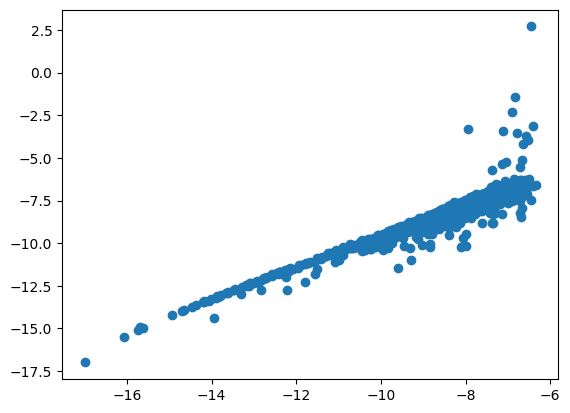

In [ ]:
plt.scatter(Gmag, Rmag)

In [ ]:
!conda install -c conda-forge mplhep

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.0



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - mplhep


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    mplhep-0.3.28              |     pyhd8ed1ab_0          35 KB  conda-forge
    mplhep_data-0.0.3          |     pyhd8ed1ab_0         4.8 MB  conda-forge
    uhi-0.3.3                  |     pyhd8ed1ab_0          16 KB  conda-forge
    ---------

In [ ]:
import mplhep as hep

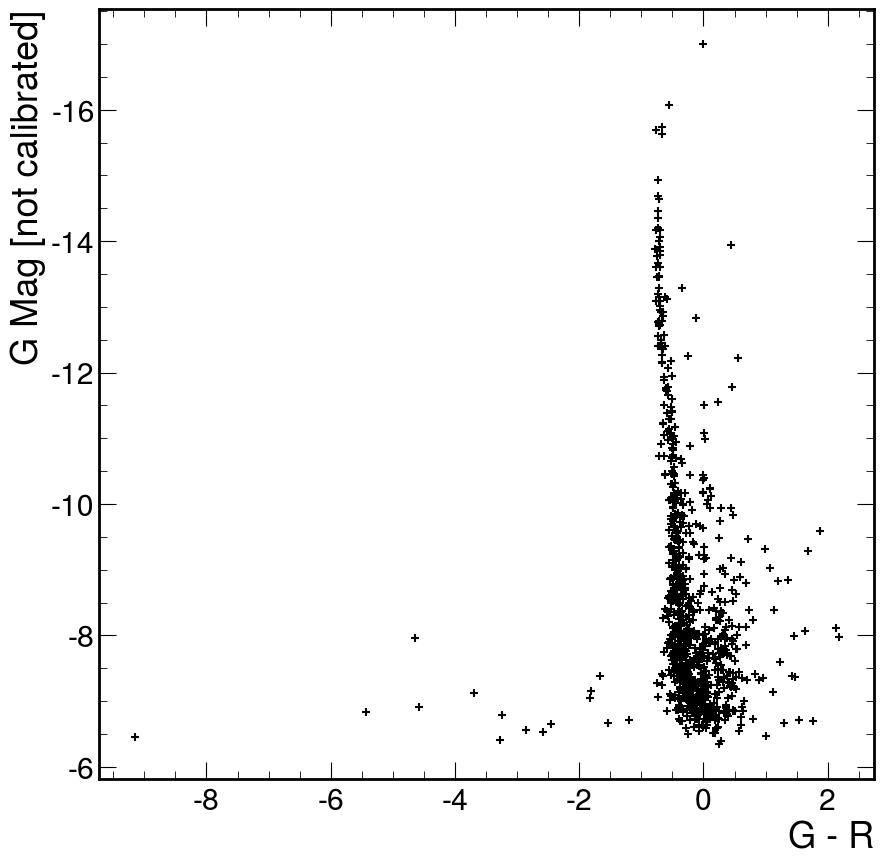

In [ ]:
plt.style.use(hep.style.ROOT)
plt.scatter(np.array(color), Gmag, marker='+', color='k')
plt.xlabel('G - R')
plt.ylabel('G Mag [not calibrated]')
plt.gca().invert_yaxis()

In [ ]:
from scipy.stats import sigmaclip
Gmag_clipped= []
color_clipped = []
color = np.array(color)
for i, c in enumerate(color):
    if c > color.mean() - color.std() and c < color.mean() + color.std():
        color_clipped.append(c)
        Gmag_clipped.append(Gmag[i])
    else:
        None

print(color.shape, len(color_clipped), len(Gmag_clipped))

(881,) 792 792


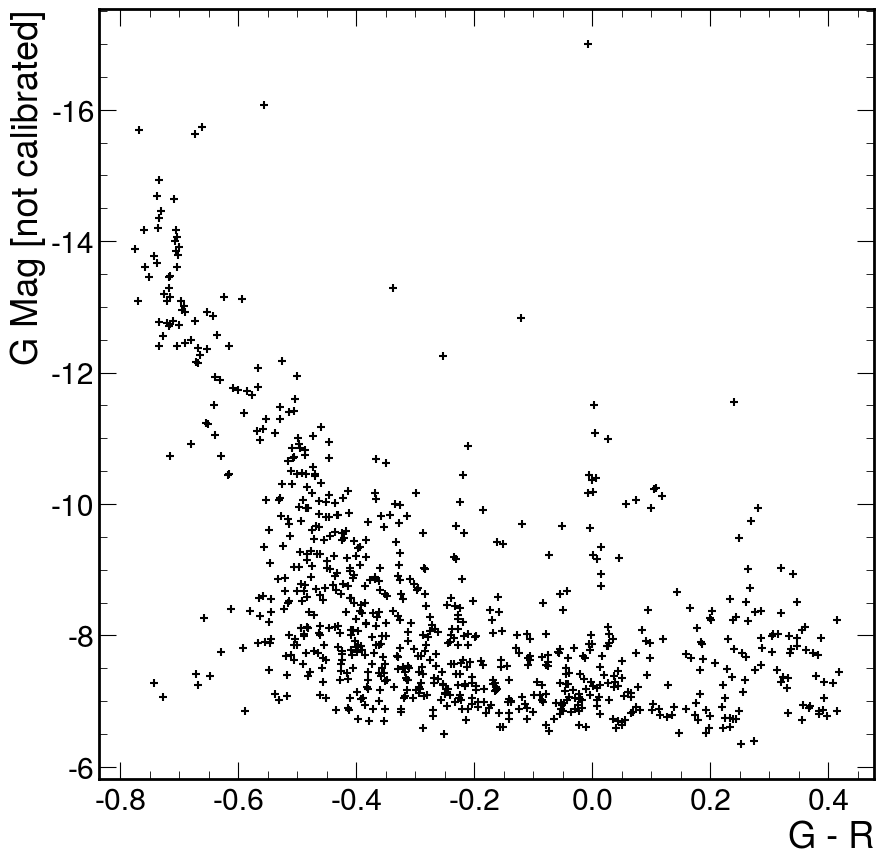

In [ ]:
plt.scatter(np.array(color_clipped), Gmag_clipped, marker='+', color='k')
plt.xlabel('G - R')
plt.ylabel('G Mag [not calibrated]')
plt.gca().invert_yaxis()

##Reference Star Calibration

In [ ]:
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.wcs.utils import skycoord_to_pixel

wcs = WCS(header_g)
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 265.063734627  -32.2468801385  
CRPIX : 1527.5  1021.5  
CD1_1 CD1_2  : 2.12192623925e-06  0.000159069433618  
CD2_1 CD2_2  : -0.000159069433618  2.12192623925e-06  
NAXIS : 3054  2042


Set OBSGEO-B to   -30.167655 from OBSGEO-[XYZ].
Set OBSGEO-H to     2197.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [ ]:
RA = ['17h39m37.6s',
'17h40m01.0s',
'17h40m11.1s',
'17h40m43.4s',
'17h40m58.5s']

DEC = ['-32d19m13s',
'-32d12m04s',
'-32d15m24s',
'-32d09m21s',
'-32d12m52s']

ra = Angle(RA)
dec = Angle(DEC)
ref_coord = SkyCoord(ra, dec, frame='icrs')
print(f'RA = {ra}; DEC = {dec}')
print(ref_coord)

RA = [17.66044444 17.66694444 17.66975    17.67872222 17.68291667] hourangle; DEC = [-32.32027778 -32.20111111 -32.25666667 -32.15583333 -32.21444444] deg
<SkyCoord (ICRS): (ra, dec) in deg
    [(264.90666667, -32.32027778), (265.00416667, -32.20111111),
     (265.04625   , -32.25666667), (265.18083333, -32.15583333),
     (265.24375   , -32.21444444)]>


In [ ]:
ref_xy = skycoord_to_pixel(ref_coord,wcs)

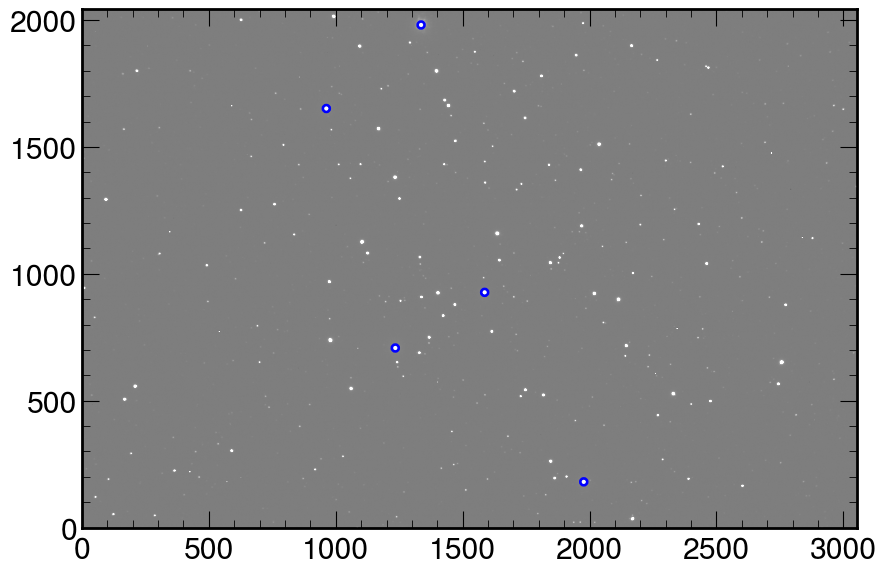

In [ ]:
ref_positions = np.transpose((ref_xy[0], ref_xy[1])) #Positions are transposed by default.
apertures = CircularAperture(ref_positions, r=5) #This defines an 'aperture' by radius around each source. The pixel values inside the aperture are summed to yield the photon count of the star.

#Lets plot our image again with the apertures overplotted to see how many stars we found.
plt.figure(figsize=(10,10))
plt.imshow(data_sub, origin='lower', cmap = "gray", vmin=m-s, vmax =m+s)
v = apertures.plot(color='blue', lw=5, alpha=1)
plt.show()

In [ ]:
positions, sums_g, sums_r, data_sub, data_sub02 = photometry(image_g, image_r)

ref_apertures = CircularAperture(ref_positions, r=5)

phot_table = aperture_photometry(data_sub, ref_apertures)
ref_g_uncali = -2.5*np.log10(phot_table['aperture_sum']*1.6)

phot_table2 = aperture_photometry(data_sub02, ref_apertures)
ref_r_uncali = -2.5*np.log10(phot_table2['aperture_sum']*1.6)

In [ ]:
print(ref_g_uncali)

print(ref_r_uncali)

print(phot_table2)

    aperture_sum   
-------------------
 -16.24468092081028
-16.563413753852682
-16.141410850629768
 -16.17563215567951
 -17.41898606962734
    aperture_sum   
-------------------
-15.568053650679614
-15.995143242415015
-15.464807077450718
 -15.40860882423927
-17.367397257260535
 id      xcenter            ycenter          aperture_sum   
           pix                pix                           
--- ------------------ ------------------ ------------------
  1 1977.3192803503046  180.0447267494792 1054633.2941107843
  2 1234.6827588882802  707.5159396202791  1562922.035544459
  3 1586.7804964251177  926.7418171003059  958965.2022762324
  4  962.8809142455033 1651.2456841911462  910591.4056697151
  5 1336.1989025269602 1980.5066054011454  5531449.098080564


-23.20482475011991
slope:  1
y intercept:  23.20482475011992


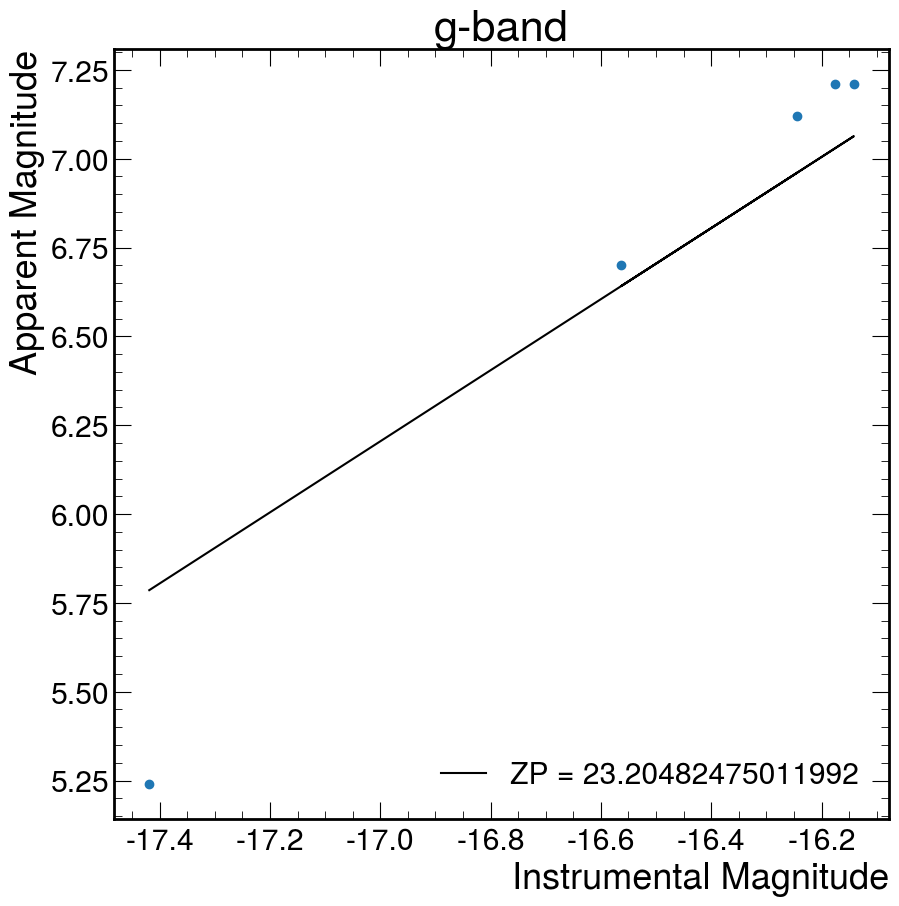

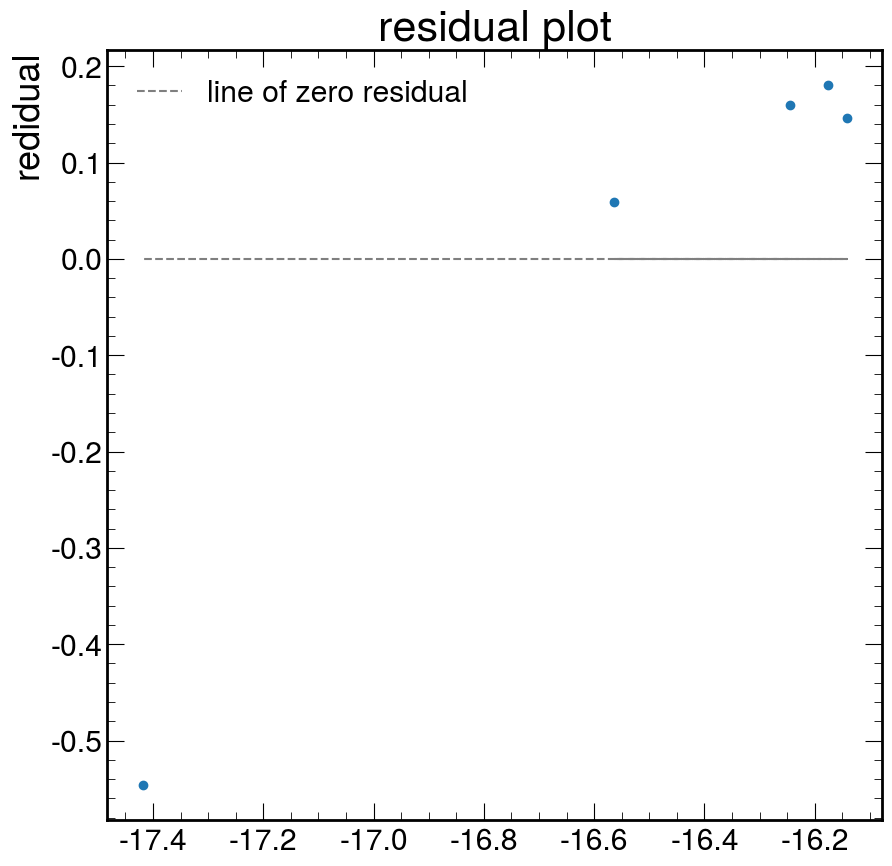

In [ ]:
x = ref_g_uncali
y = np.array([7.12, 6.70, 7.21, 7.21, 5.24])

print(np.mean(x-y))

xbar = np.mean(x)
ybar = np.mean(y)
numerator=np.sum(x*y-x*ybar)
denominator=np.sum(x*x-x*xbar)
m = 1
#numerator/denominator
print ("slope: ", m)
b_g = ybar-m*xbar
print ("y intercept: ", b_g)
line = m*x +b_g


fit_line = plt.plot(x, line, color='black', label=f"ZP = {b_g}")
plt.legend(loc='lower right')
plt.scatter(x,y)
plt.xlabel("Instrumental Magnitude")
plt.ylabel("Apparent Magnitude")
plt.title('g-band')
plt.show()

residual_g = y - line
resid_line = x*0

plt.scatter(x, residual_g)
plt.title("residual plot")
plt.ylabel("redidual")
plt.plot(x,resid_line, color='black', ls='--',alpha =0.5, label="line of zero residual")
plt.legend()
plt.show()

In [ ]:
fit=np.polyfit(x,y,4)
print(fit)

[-2.35273178e+01 -1.56204112e+03 -3.88792420e+04 -4.29968295e+05
 -1.78263425e+06]


-22.65680201040903
slope:  1
y intercept:  22.65680201040903


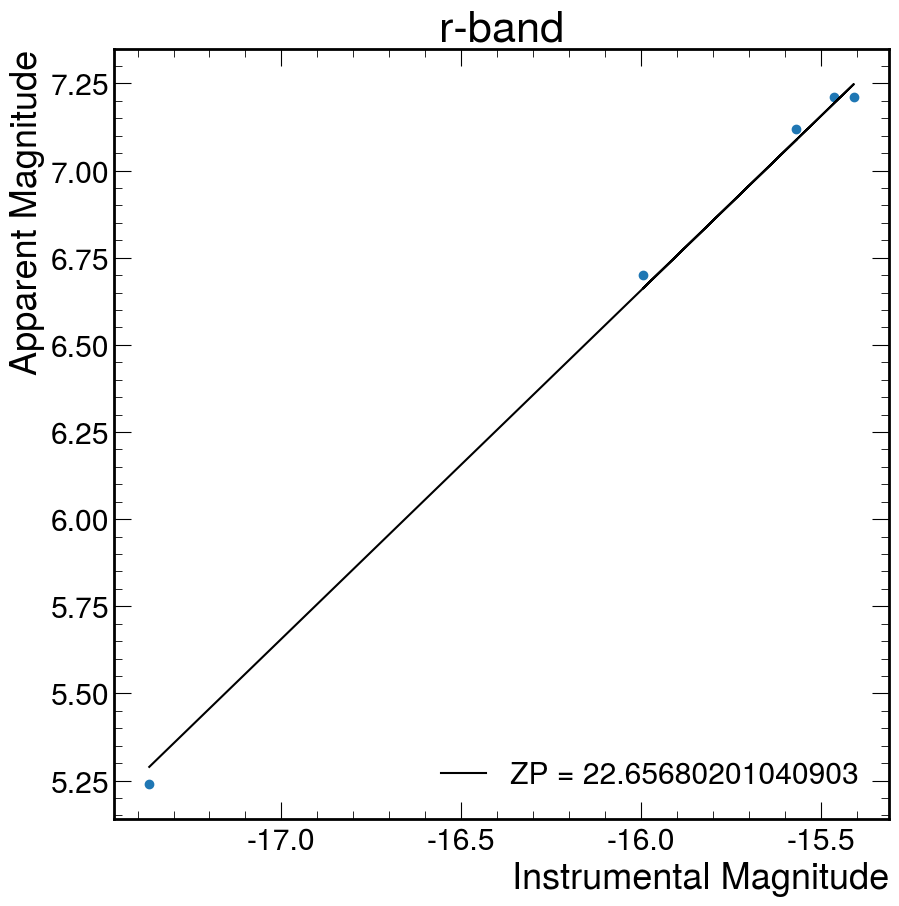

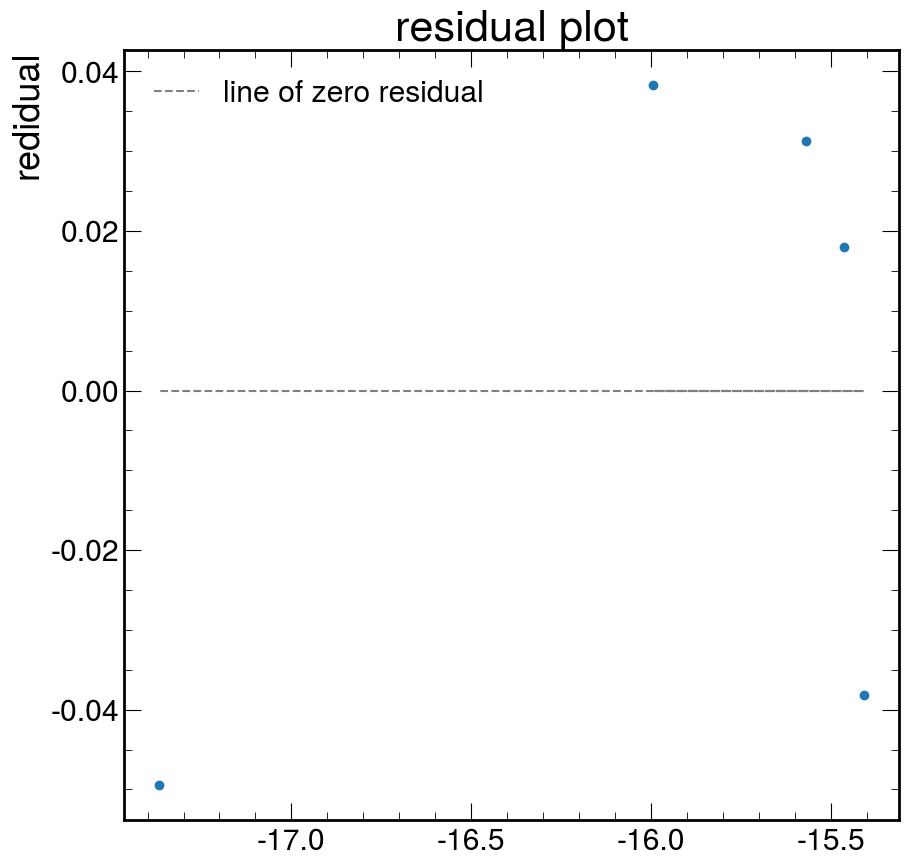

In [ ]:
x = ref_r_uncali
y = np.array([7.12, 6.70, 7.21, 7.21, 5.24])

print(np.mean(x-y))

xbar = np.mean(x)
ybar = np.mean(y)
numerator=np.sum(x*y-x*ybar)
denominator=np.sum(x*x-x*xbar)
m = 1
#numerator/denominator
print ("slope: ", m)
b_r = ybar-m*xbar
print ("y intercept: ", b_r)
line = m*x +b_r


fit_line = plt.plot(x, line, color='black', label=f"ZP = {b_r}")
plt.legend(loc='lower right')
plt.scatter(x,y)
plt.xlabel("Instrumental Magnitude")
plt.ylabel("Apparent Magnitude")
plt.title('r-band')
plt.show()

residual_r = y - line
resid_line = x*0
plt.scatter(x, residual_r)
plt.title("residual plot")
plt.ylabel("redidual")
plt.plot(x,resid_line, color='black', ls='--',alpha =0.5, label="line of zero residual")
plt.legend()
plt.show()

In [ ]:
print(residual_r, residual_r.mean())

     aperture_sum    
---------------------
  0.03125164027058336
  0.03834123200598416
  0.01800506704168736
-0.038193186169761084
 -0.04940475314849557 -3.552713678800501e-16


In [ ]:
print(residual_g)

    aperture_sum   
-------------------
0.15985617069036007
0.05858900373276388
0.14658610050984944
0.18080740555959007
-0.5458386804925777


In [ ]:
print( residual_g.mean(), residual_r.mean())

-2.842170943040401e-15 -3.552713678800501e-16


#Add Zero Point Magnitude

In [ ]:
color_cali = color + (b_g - b_r)* np.ones(len(color))
Gmag_cali = Gmag + b_g * np.ones(len(Gmag))
Rmag_cali = Rmag + b_r * np.ones(len(Gmag))

<ipython-input-35-9ebccb2364ee>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = plt.cm.get_cmap('RdYlBu_r')


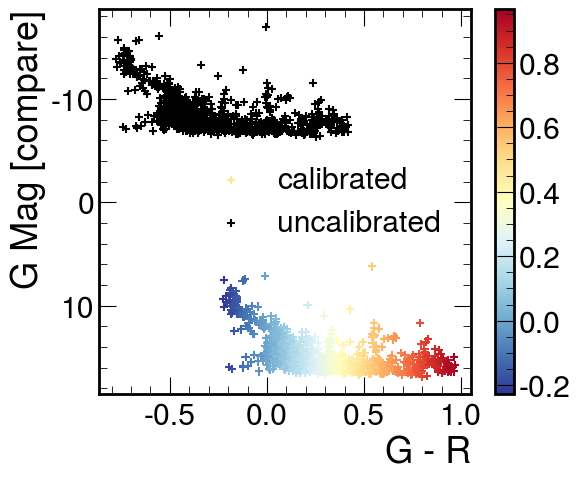

In [ ]:
Gmag_cali_clipped= []
Rmag_cali_clipped= []
color_cali_clipped = []
color_cali = np.array(color_cali)
for i, c in enumerate(color_cali):
    if c > color_cali.mean() - color_cali.std() and c < color_cali.mean() + color_cali.std():
        color_cali_clipped.append(c)
        Gmag_cali_clipped.append(Gmag_cali[i])
        Rmag_cali_clipped.append(Rmag_cali[i])
    else:
        None
#print(len(color_cali_clipped), len(color_clipped), color.shape, len(color_cali))
cmap_reversed = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(6,5))
plt.style.use(hep.style.ROOT)
plt.scatter(np.array(color_cali_clipped), Gmag_cali_clipped, marker='+', c=color_cali_clipped, cmap =cmap_reversed,label='calibrated')

plt.colorbar()
plt.scatter(np.array(color_clipped), Gmag_clipped, marker='+', c = 'k',label='uncalibrated')
plt.xlabel('G - R')
plt.ylabel('G Mag [compare]')
plt.legend()
#plt.xlim(-2, 3)
plt.gca().invert_yaxis()

In [ ]:
print(color_cali_clipped)

[0.45970269834366384, -0.019329129644701126, 0.2519620262926665, 0.22202755339832514, 0.054867433531729404, 0.1671300429680347, 0.2996216756125989, 0.34354108973567765, 0.21552883560841885, 0.20538084961742165, 0.13515907912688263, 0.03365972894608937, -0.041500821429382384, -0.18048452756225686, 0.27926483824397064, 0.44711537922715383, 0.0956112242055589, 0.3375518036010998, -0.15439199833850026, 0.21097760172788682, 0.12281106049593049, 0.43656379249015753, 0.25477141619659616, -0.09423488673176017, 0.4053489180579479, 0.11438678554079829, 0.09678334977366099, 0.19192842403967614, 0.72165520636106, 0.3624975644658077, 0.1383389194250988, 0.3433372055718733, 0.2807092640554405, 0.026247125669474514, 0.22312461887416113, 0.7402111383965027, 0.46869486838185015, 0.5989935491175551, 0.5740523688036863, 0.0531785317451785, 0.12196687424087393, 0.7871783560414496, -0.015751808446601956, 0.5263572821844207, 0.6422939163683345, 0.08576388770580756, 0.7725931965843156, 0.02762111131268874, 0

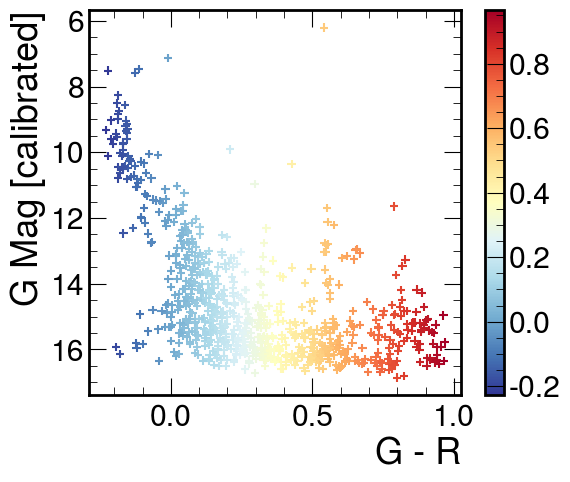

In [ ]:
plt.figure(figsize=(6,5))
plt.style.use(hep.style.ROOT)
plt.scatter(np.array(color_cali_clipped), Gmag_cali_clipped, marker='+', c = color_cali_clipped, cmap = cmap_reversed,label='calibrated')
plt.colorbar()
plt.xlabel('G - R')
plt.ylabel('G Mag [calibrated]')
#plt.xlim(-2, 3)
plt.gca().invert_yaxis()

#Error Analysis

In [ ]:
qe_g, qe_r = 0.65, 0.4

In [ ]:
S_g = np.power(10,np.array(Gmag)*(-2.5)**(-1))*qe_g
S_r = np.power(10,np.array(Rmag)*(-2.5)**(-1))*qe_r
S_color = color_cali

In [ ]:
sig_ro = 14.5
sig_dc = np.sqrt(0.03)

bkg01_table = aperture_photometry(bkg0.rms(), CircularAperture(positions, r=5))
sig_bkg01 = np.sqrt(bkg01_table['aperture_sum']*1.6*qe_g)
bkg02_table = aperture_photometry(bkg0.rms(), CircularAperture(positions, r=5))
sig_bkg02 = np.sqrt(bkg02_table['aperture_sum']*1.6*qe_r)

sig_s01 = np.sqrt(S_g*qe_g)
sig_s02 = np.sqrt(S_r*qe_r)

sig_fit_g, sig_fit_r = np.power(10,np.array(residual_g.mean())*(-2.5)**(-1))*qe_g, np.power(10,np.array(residual_r.mean())*(-2.5)**(-1))*qe_g


In [ ]:
print(S_g.mean(), np.mean(sums_g))

23880.939211019842 36739.90647849204


In [ ]:
SNR_g = S_g/np.sqrt(sig_ro**2+sig_dc**2+sig_bkg01**2+sig_s01**2+sig_fit_g**2)
SNR_r = S_r/np.sqrt(sig_ro**2+sig_dc**2+sig_bkg02**2+sig_s02**2+sig_fit_r**2)

In [ ]:
sig_color = np.sqrt(SNR_g**(-2)+SNR_g**(-2))

In [ ]:
print(SNR_g.mean(), SNR_r.mean(), sig_color.mean()) #SNR in g and r filter, and error in g-r color index (in magnitude)

79.20326529923884 61.56687208963358 0.05576400429734319


In [ ]:
print(20*np.log(SNR_g.mean()),20*np.log(SNR_r.mean())) #in dB unit

87.44035052992501 82.40247870250917
